# Denoising with a synthetic DNN prior

Suppose we are given a prior $G$ parameterized by an expansive DNN. Suppose the prior $G$ maps a $k$-dimensional input to a $n$-dimensional output, where $K \ll N$. Furthermore, we let the weights be Gaussian distributed, and the activation functions are ReLus.

We consider the classical image or data denoising problem, where the goal is to remove zero-mean white Gaussian noise from a given image or data point. In more detail, our goal is to obtain an estimate of a vector $y_0 \in \mathbb R^n$ from the noisy observation
$$
y = y_0 + \eta, 
$$
where $\eta$ is zero-mean Gaussian noise with covariance matrix $\sigma^2/n I$, and $y_0$ lies in the range of the generator, i.e., $y_0=G(x_0)$.

We consider the following two-step denoising algorithm:
1. Obtaine an estimate $\hat x$ of the latent representation by minimizing the empirical loss
$$
f(x) = \|G(x) - y_0\|_2^2
$$
using gradient descent.
2. Obtain an estimate of the image as $\hat y = G(\hat x)$.

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import numpy as np
from IPython.core.debugger import Tracer

import matplotlib.pyplot as plt

# Denoising with a random prior 
Suppose we add Gaussian noise to the output. What is the denoising rate if we reconstruct the input from the output, with empirical risk minimization?

In [2]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 0.1)
            
def remove_grad(m):
    if type(m) == nn.Linear:
        m.weight.requires_grad = False

# generate a random DNN prior
def generate_random_prior(K,n_hidden = 500, n_out = 1500):
    # define the network
    net = nn.Sequential(
        nn.Linear(in_features=K, out_features=n_hidden, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=n_hidden, out_features=n_out, bias=False),
        nn.ReLU(),
    )
    # initialize weights
    net.apply(init_weights)
    net.apply(remove_grad)    
    return net

In [3]:
# function to estimate the latent representation
def invert_prior(net, noisy_image,latent_param,learning_rate=0.1,num_steps=500):
    optimizer = torch.optim.SGD([latent_param], lr=learning_rate) 
    iter_idx = 0
    while iter_idx <= num_steps:
        # correct the values of updated input signal
        optimizer.zero_grad()
        output = net(latent_param)
        loss = F.mse_loss(output, noisy_image, size_average=False)
        loss.backward()
        optimizer.step()
        iter_idx += 1
    return latent_param

# denoise by recovering estimating a latent representation and passing that through the decoder
def denoise(net,noisy_image,K):
    rec_rep = Variable(torch.randn(K), requires_grad=True)
    rec_rep = invert_prior(net, noisy_image, rec_rep)
    return net(rec_rep)

def sqnorm(a):
    return sum(a.data.numpy()*a.data.numpy())

First, we demonstrate that in the noiseless case, we can perfectly recover the latent representation, provided $K$ is not too large:

In [4]:
n = 1500
K = 50
net = generate_random_prior(K)
# generate random latent representation
orig_rep = Variable( torch.randn(K) )
orig_img = net(orig_rep) # 784 tensor

sigma = 0.0
noise = Variable( torch.randn(n) )
noise = noise * (sigma*np.sqrt(sqnorm(orig_img) / sqnorm(noise)))
noisy_img = orig_img + noise

In [5]:
# recover image
rec_rep = Variable(torch.randn(K), requires_grad=True)
rec_rep = invert_prior(net, noisy_img, rec_rep, learning_rate=0.02,num_steps=500)
MSErep = sqnorm(orig_rep - rec_rep) / sqnorm(rec_rep)
# MSE in image space:
rec_img = net(rec_rep)
MSE = sqnorm(orig_img - rec_img) / sqnorm(orig_img)
print("Mean square error in latent space (0 if perfect recovery): ",MSErep)
print("Mean square recovery error (0 if perfect recovery): ",MSE)

Mean square error in latent space (0 if perfect recovery):  3.7745489212406675e-15
Mean square recovery error (0 if perfect recovery):  1.9096982653213176e-14


Generate the plots in the paper on the mean squared error:

In [9]:
def sqnorm(a):
    return np.sum(a.data.numpy()*a.data.numpy())

def simulate(Ks,numit,Sigmas):
    MSEimg = np.zeros(len(Ks))
    MSErep = np.zeros(len(Ks))
    for i,(K,sigma) in enumerate(zip(Ks,Sigmas)):
        for it in range(numit):
            net = generate_random_prior(K)
            # generate random input to the network
            orig_rep = Variable( torch.randn(K) ) 
            orig_img = net(orig_rep)
            # add noise
            noise = Variable( sigma * torch.randn(n) / np.sqrt(n) )
            #noise = noise * (sigma*np.sqrt(sqnorm(orig_rep) / sqnorm(noise)))
            noisy_img = orig_img + noise
            if(sigma > 0):
                SNR = sqnorm(orig_img) / sqnorm(noise)
                SNRrep = sqnorm(orig_rep) / sqnorm(noise)
                #print("SNR/signal: ", SNR, SNRrep )
            # recover image
            rec_rep = Variable(torch.randn(K), requires_grad=True)
            rec_rep = invert_prior(net, noisy_img, rec_rep,0.02)
            # MSE in image space:
            rec_img = net(rec_rep)
            MSE = sqnorm(orig_img - rec_img)
            MSEimg[i] += MSE/numit
            # MSE in latent space:
            MSE = sqnorm(orig_rep - rec_rep)
            MSErep[i] += MSE/numit
    return MSErep,MSEimg

In [15]:
numit = 100
Ks = [5+10*i for i in range(6)]
Sigmas = [1.]*len(Ks)
MSErep,MSEimg = simulate(Ks,numit,Sigmas)

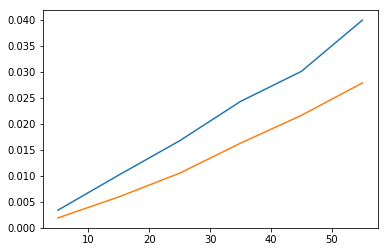

In [16]:
plt.plot(Ks,MSEimg)
plt.plot(Ks,10*MSErep)
plt.show()

mtx = np.array([Ks, MSEimg, 10*MSErep])
np.savetxt("./denoise_random_dnn_k.dat", mtx.T , delimiter='\t')

In [17]:
numit = 100
Sigmas = [0.5*i for i in range(10)] 
Ks = [30]*len(Sigmas)

MSErep,MSEimg = simulate(Ks,numit,Sigmas)

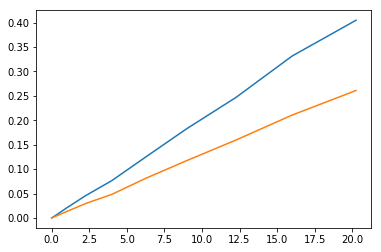

In [18]:
Sigmas = np.array(Sigmas)
plt.plot(Sigmas**2,MSEimg)
plt.plot(Sigmas**2,10*MSErep)
plt.show()

mtx = np.array([Sigmas**2, MSEimg, 10*MSErep])
np.savetxt("./denoise_random_dnn_sigma.dat", mtx.T , delimiter='\t')

## Visualizing the loss surface

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

def l1norm(a):
    return sum(abs(a.data.numpy()))
def evaluate(z,y):
    x = Variable( torch.ones(2) )
    x.data[0] = z
    x.data[1] = y
    loss = l1norm(net(x) - orig_img)

K = 2
net = generate_random_prior(K,n_hidden = 150, n_out = 512)
# generate latent representation at (1,0)
orig_rep = Variable( torch.ones(2) )
orig_rep.data[1] = 0
orig_img = net(orig_rep) # 784 tensor
print(orig_rep.data)

# print coordinates plotted with pgfplots
def get_grid(zgrid,ygrid):
    L = len(zgrid)
    X = np.zeros((L,L))
    Y = np.zeros((L,L))
    Z = np.zeros((L,L))

    for i,y in enumerate(ygrid):
        for j,z in  enumerate(zgrid):
            x = Variable( torch.ones(2) )
            x.data[0] = z
            x.data[1] = y
            loss = sqnorm(net(x) - orig_img)
            #loss = l1norm(net(x) - orig_img)
            X[i,j] = y
            Y[i,j] = z
            Z[i,j] = loss
        #    print(y,z,loss)
        #print()
    return X,Y,Z


 1
 0
[torch.FloatTensor of size 2]



#### Visualizaiton in relevant regime

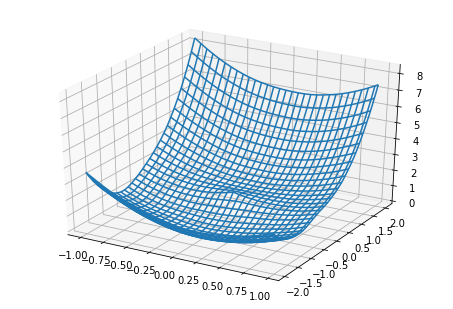

In [23]:
N = 30
zgrid = [2*i/N  for i in range(-N,N)]
ygrid = [i/N for i in range(-N,N)]
X,Y,Z = get_grid(zgrid,ygrid)

fig = plt.figure()
ax = Axes3D(fig) #<-- Note the difference from your original code...
cset = ax.plot_wireframe(X, -Y, Z)
ax.clabel(cset, fontsize=9, inline=1)
plt.show()

#### Visualizaiton around the critical point at $-\rho x_\ast$

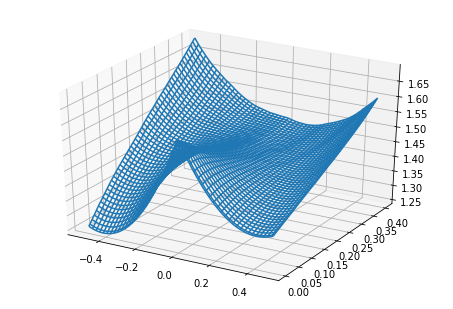

In [25]:
N = 50
zgrid = [0.2*i/N - 0.2  for i in range(-N,N)]
ygrid = [0.5*i/N for i in range(-N,N)]
Xzoom,Yzoom,Zzoom = get_grid(zgrid,ygrid)

fig = plt.figure()
ax = Axes3D(fig)
cset = ax.plot_wireframe(Xzoom, -Yzoom, Zzoom)
ax.clabel(cset, fontsize=9, inline=1)
plt.show()

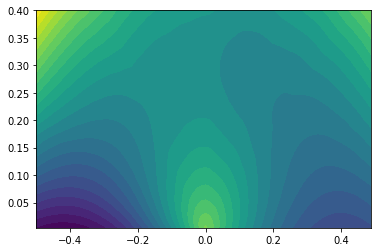

In [26]:
plt.contourf(Xzoom, -Yzoom, Zzoom,25)
plt.show()